<a href="https://colab.research.google.com/github/umbertoselva/EN-to-IT-FR-DE-Translator/blob/main/EN_to_IT_FR_DE_Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EN to IT, FR, DE Translator

The goal of this Google Colab project will be to implement a small "Google Translate-style" translator with the Huggingface Transformer library and a Gradio interface.

We shall be able to translate single sentences from English into Italian, French and German.

### Installation

We will need: 

1.   Huggingface's `transformer` library to leverage pretrained NLP models;
2.   `sentencpiece`, which will turn out to be a requirement in order to use one such model;
3. `gradio` to create the user interface.

In [1]:
!pip install transformers sentencepiece gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.4 MB/s 
     |████████████████████████████████| 1.2 MB 29.5 MB/s 
     |████████████████████████████████| 5.1 MB 48.4 MB/s 
     |████████████████████████████████| 6.6 MB 55.1 MB/s 
     |████████████████████████████████| 596 kB 52.2 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 1.1 MB 44.8 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 2.0 MB 39.1 MB/s 
     |████████████████████████████████| 212 kB 55.0 MB/s 
     |████████████████████████████████| 256 kB 59.9 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 140 kB 62.4 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 27

### Setting up the Transformers Pipeline

In [2]:
from transformers import pipeline

It is possible to use Huggingface's default pipeline on a specific NLP task just by passing a task identifier as argument. 

In the case of Machine Translation, it also possible to specify a source and a destination language with the `translation_xx_to_yy` indentifier.

Unless a model is specified with the appropriate keyword argument, `pipeline` defaults to using `t5-base`, an encoder-decoder model. Not all source-to-destination language combinations are available with this model. In fact, whereas EN-to-FR and EN-to-DE are available, EN-to-IT is not. For that, we'll have to resort to a different model.

Let's set up the English-to-French and English-to-German pipelines first.


In [3]:
transl_pipe_enfr = pipeline('translation_en_to_fr')
transl_pipe_ende = pipeline('translation_en_to_de')

No model was supplied, defaulted to t5-base (https://huggingface.co/t5-base)


Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,
No model was supplied, defaulted to t5-base (https://huggingface.co/t5-base)


A line such as `transl_pipe_enit = pipeline('translation_en_to_it')` would throw an error, because translation into Italian appears not to be available with the `t5-base` model. 

Let's try another model available in the Huggingface database. In order to do so, we need to specify the repo with the `model=""` keyword. This model requires ``sentencepiece`` to be installed.

In [4]:
transl_pipe_enit = pipeline('translation_en_to_it', model='Helsinki-NLP/opus-mt-en-it')

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/327M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/771k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/795k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/marian/tokenization_marian.py:198: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


### The Translator function

Now that we have three pipelines ready, let's create a custom function to process the user input.

We want the user to be able to choose the destination language and then submit an English sentence for translation.

In [5]:
def translator(destination_language, text):
  
  if destination_language == 'Italian':
    translation = transl_pipe_enit(text)

  if destination_language == 'French':
    translation = transl_pipe_enfr(text)

  elif destination_language == 'German':
    translation = transl_pipe_ende(text)
  
  return translation[0]['translation_text']


In order to understand the last line, let's check what kind of object our pipelines return

In [6]:
input_example = "Hello, how are you?"
translation = transl_pipe_enit(input_example)
translation

[{'translation_text': 'Ciao, come stai?'}]

In [7]:
type(translation)

list

In [8]:
translation[0]

{'translation_text': 'Ciao, come stai?'}

In [9]:
type(translation[0])

dict

The object returned by the pipeline is a list, whose first item at index 0 is a dict. The actual translation text is stored as the value correspoding to the 'translation_text' key. That's why in our custom function above we extract the text with `translation[0]['translation_text']`.

### The Interface

We are finally ready to build the interface.

This will receive two inputs in the same order as expected by our `translator` function:

*   The Radio block will return the first argument for our function, namely the `destination_language`. Only three inputs will be available: `'Italian'`, `'French'` and `'German'`. The returned string will be checked by the if-conditions in our function.
*   The Textbox block will return the second argument, `text`, also a string, which will be fed by our function to the pipeline corresponding to the selected destination language.

By pressing the 'submit' button, the user will then effectively pass those two arguments to the `translator` function and execute it. The returned object, the translated text, will be displayed in the Output block.



In [10]:
import gradio as gr

In [11]:
interface = gr.Interface(
    
    # the function called by the "submit" button
    fn = translator,

    # the Input block
    inputs = [
              # the Radio block
              gr.Radio(['Italian', 'French', 'German'], 
                       label='Choose the destination language'),
              # the Textbox block
              gr.Textbox(lines=5, label= 'Enter your sentence here', 
                         placeholder='Enter your text here')         
    ],

    # the Output block
    outputs='text',
    allow_flagging='never' # to remove the "flag" button from the ouptut block
)

In [12]:
interface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://24261.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7fa42beeb310>,
 'http://127.0.0.1:7860/',
 'https://24261.gradio.app')

This is what the Interface will look like:

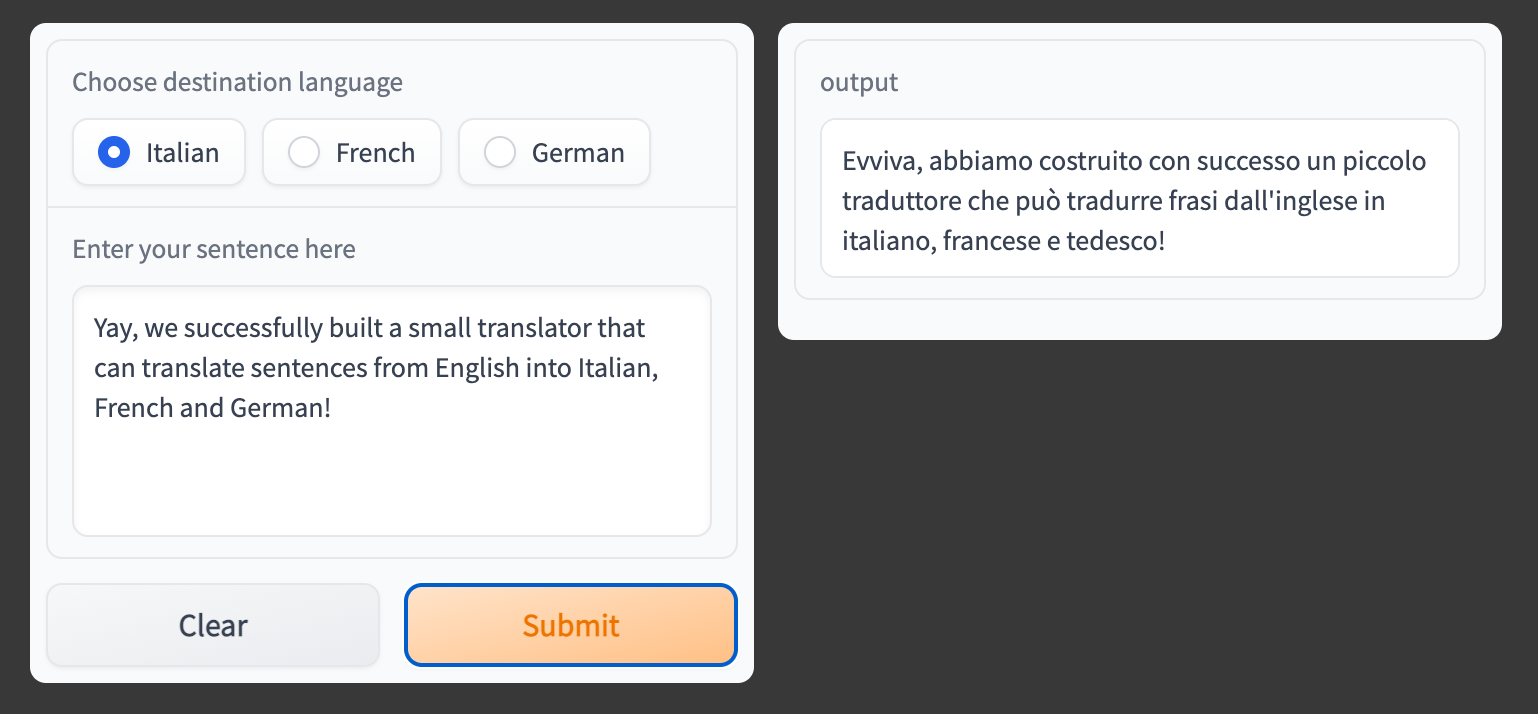